# Import libraries

In [1]:
# python libraries 
from glob import glob
import json
import os
import math

# to split train and test
from sklearn.model_selection import train_test_split

# torch libraries 
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision.io import read_image
import torchvision.transforms.v2 as transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# matplotlib for plotting
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# to track progress
from tqdm import tqdm

# for OCR
import pytesseract

# for image operations during text detection
from PIL import Image

# from text detection and data series generation
import pandas as pd
import re

# Set constants

In [2]:
# random seed
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

# paths
model_path = "..\\model\\ft_frcnn_min_loss.pt"
pytesseract.pytesseract.tesseract_cmd = r'C:\Users\prtkm\AppData\Local\Programs\Tesseract-OCR\tesseract'

# image size
img_size=256

# transformations applied
transform = transforms.Compose([transforms.Grayscale(num_output_channels = 1),
                                transforms.Resize(size = (img_size,img_size), antialias=True),
                                transforms.ToDtype(dtype = torch.float32, scale = True)])

# dict to encode labels
label_encode_dict = {
                        'chart_title':0,
                        'axis_title':1,
                        'tick_label':2,
                        'bar':3,
                        'other':4
                    }

# dict to encode label color for visualization
label_color_dict = {
                        0:'b',
                        1:'g',
                        2:'r',
                        3:'c',
                        4:'k'
                    }

# Get Image


Please set file path to desired bar chart

In [3]:
# image path
image_path = '..\\data\\bar_charts\\images\\00eb4cddbff9.jpg'

# read image
img = read_image(path = image_path)


# Getting original img size
wt = img.shape[2]
ht = img.shape[1]
        
# apply transforms
img_transformed = transform(img)

# Object Detection Module

## Get Faster RCNN Model

In [4]:
# to train on gpu if available 
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = len(label_encode_dict)

try:
    # get trainined model
    model = torch.load(model_path)
    print("Using Trained Model")
except:
    # if we can't get the model
    print("Cannot find model. Please fix model path")

# move model to the right device
model.to(device)

Using Trained Model


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

## Non Max Suppression to reduce number of boxes

In [5]:
# the function takes the prediction and the iou threshold.

def apply_nms(prediction, iou_thresh=0.3):   
    nms_pred = prediction
    for elem in nms_pred:
        # torchvision returns the indices of the bboxes to keep
        keep = torchvision.ops.nms(elem['boxes'], elem['scores'], iou_thresh)
    
        elem['boxes'] = elem['boxes'][keep]
        elem['scores'] = elem['scores'][keep]
        elem['labels'] = elem['labels'][keep]
    
    return nms_pred


## Apply reverse transformations on boxes to get original bboxes

In [6]:
def rev_transform(preds, wt, ht):
    rev_preds = preds
    for i in range(0,len(rev_preds)):
        if len(rev_preds) == 1:
            rev_preds[i]['boxes'][:, 0] *= wt/img_size
            rev_preds[i]['boxes'][:, 1] *= ht/img_size
            rev_preds[i]['boxes'][:, 2] *= wt/img_size
            rev_preds[i]['boxes'][:, 3] *= ht/img_size
        else:
            rev_preds[i]['boxes'][:, 0] *= wt[i]/img_size
            rev_preds[i]['boxes'][:, 1] *= ht[i]/img_size
            rev_preds[i]['boxes'][:, 2] *= wt[i]/img_size
            rev_preds[i]['boxes'][:, 3] *= ht[i]/img_size
    
    return rev_preds

## Classify bounding boxes and infer chart orientation

In [7]:
def classify_bboxes_and_get_orientation(preds):
    classified_preds = preds
    for elem in classified_preds:
        # to classify bars
        
        # finding bar bounding boxes
        bar_indices = torch.where(elem['labels'] == 3, True, False)
        bar_boxes = elem['boxes'][bar_indices] 
        
        # finding minimum x for all bounding boxes. Will be used below
        bar_min_x = torch.min(bar_boxes[:,0])
        
        # alloting bars
        elem['bar'] = bar_boxes
        
        # to classify axis_title
        
        # finding axis_title bounding boxes
        axis_title_indices = torch.where(elem['labels'] == 1, True, False)
        axis_title_boxes = elem['boxes'][axis_title_indices] 
        
        # finding y axis title
        # y axis title will have their x_max as less then minimum x for bars
        y_indices = torch.where(axis_title_boxes[:,2] < bar_min_x, True, False)
        
        # alloting axis_title
        elem['y_axis_title'] = axis_title_boxes[y_indices]
        elem['x_axis_title'] = axis_title_boxes[~y_indices]
        
        # to classify chart_title
        
        # finding chart_title bounding boxes
        chart_title_indices = torch.where(elem['labels'] == 0, True, False)
        chart_title_boxes = elem['boxes'][chart_title_indices] 
        
        # alloting chart_title
        elem['chart_title'] = chart_title_boxes
        
        # to classify x_ticks and y_ticks
        
        # finding tick_label bounding boxes
        boxes_indices_to_consider = torch.where(elem['labels'] == 2, True, False)
        boxes_to_consider = elem['boxes'][boxes_indices_to_consider]
        
        # finding y indices
        # all y_ticks will have their x_max as less then minimum x for bars
        y_indices = torch.where(boxes_to_consider[:,2] < bar_min_x, True, False)
        
        # alloting x and y ticks
        elem['y_ticks'] = boxes_to_consider[y_indices]
        elem['x_ticks'] = boxes_to_consider[~y_indices]
        
        # delete unwanted keys
        elem.pop('boxes', None)
        elem.pop('labels', None)
        elem.pop('scores', None)
        
        # to get chart orientation
        
        # we check if bars have greater length in x axis or y axis
        # if greater length in x axis then it is a horizontal bar
        # else it is a vertical bar
        
        xlen_ylen_ratios = [(elem[2]-elem[0])/(elem[3]-elem[1]) for elem in bar_boxes]
        xlen_ylen_ratios = torch.tensor(xlen_ylen_ratios, dtype=torch.float32)
        median_val = torch.median(xlen_ylen_ratios)
        if median_val <= 1:
            elem['chart_type'] = 'vertical_bar'
        else:
            elem['chart_type'] = 'horizontal_bar'
    
    return classified_preds

# Text Detection Module

## Function to get text inside bounding box

In [8]:
def get_text_from_bb(bb, img):
    apil = transforms.ToPILImage()(img)
    apil = apil.convert('L')
    # crop wants box coordinates as (left, upper, right, lower) with (0,0) in the upper left corner  
    # therefore coordinates will be xmin, ymin, xmax, ymax
    apil_crop = apil.crop((int(bb[0].item()), int(bb[1].item()), int(bb[2].item()), int(bb[3].item())))

    # some text might be rotated 90 deg clockwise therefore we have to rotate 90 deg counterclockwise
    # some text might be rotated 45 deg clockwise therefore we have to rotate 45 deg counterclockwise
    # some text might be rotated 0 deg clockwise therefore we do not rotate it
    # some text might be rotated 45 deg counterclockwise therefore we have to rotate 315 deg counterclockwise
    # some text might be rotated 90 deg counterclockwise therefore we have to rotate 270 deg counterclockwise
    # since we don't know the original orientation of the text, we predict text on all 5 orientations
    # and take the value with highest confidence value

    images = []

    # to rotate 90 deg counterclockwise
    images.append(apil_crop.rotate(angle=90, expand=1, resample=Image.Resampling.BICUBIC, fillcolor='white'))

    # to rotate 45 deg counterclockwise
    a = apil_crop.rotate(angle=45, expand=1, resample=Image.Resampling.BICUBIC, fillcolor='white')
    # we have to crop it a bit if text is big, then bounding box can also include text from other entities
    w,h = a.size
    a = a.crop((0, int(h/3), w, int(2*h/3)))
    images.append(a)

    # to rotate 0 deg
    images.append(apil_crop)

    # to rotate 315 deg counterclockwise
    a = apil_crop.rotate(angle=315, expand=1, resample=Image.Resampling.BICUBIC, fillcolor='white')
    # we have to crop it a bit if text is big, then bounding box can also include text from other entities
    w,h = a.size
    a = a.crop((0, int(h/3), w, int(2*h/3)))
    images.append(a)

    # to rotate 270 deg counterclockwise
    images.append(apil_crop.rotate(angle=270, expand=1, resample=Image.Resampling.BICUBIC, fillcolor='white'))

    # predict text all orientations
    conf_text = pd.DataFrame({'conf':[-1.0],'text':[' ']})
    for elem in images:
        ct = pytesseract.image_to_data(elem, output_type='data.frame',config=' --oem 3 --psm 6')
        # get values with confidence != -1 
        ct = ct[ct.conf != -1][['conf', 'text']]
        # add values to conf_text if ct is not empty
        if not ct.empty:
            ct['text'] = ct['text'].astype(str)
            mean_conf = ct.agg({'conf' : ['mean']}).to_numpy()[0][0]
            cat_text = ' '.join(ct.text) 
            # sanitize text
            cat_text_san = re.sub('[^A-Za-z0-9. ]+', '', cat_text).rstrip().lstrip()
            # check ratio of deleted items
            san_ratio = len(cat_text_san)/len(cat_text)
            # only add values if it makes sense
            if san_ratio >= 0.7 and len(cat_text)>1:
                conf_text.loc[-1] = [mean_conf, cat_text_san]
                conf_text = conf_text.reset_index(drop=True)
        
    conf_text = conf_text.loc[conf_text['conf'].idxmax()]
    pred_text = conf_text['text']
    # check if pred_text is float or string
    try:
        pred_text = float(pred_text)
    # this is run when pred_text is a string
    except ValueError:
        # remove . marks
        pred_text = re.sub('[^A-Za-z0-9 ]+', '', pred_text)
    return pred_text

## Function to get text predicitons

In [9]:
def get_text(preds, img):
    text_preds = preds
    if len(text_preds) == 1:
        img = [img]
    for i in range(0,len(text_preds)):
        # classify y_axis_title
        
        # check if it has values
        if text_preds[i]['y_axis_title'].numel() > 0:
            text_preds[i]['y_axis_title_text'] = []
            for elem in text_preds[i]['y_axis_title']:
                text_preds[i]['y_axis_title_text'].append(get_text_from_bb(elem,img[i]))
        
        # classify x_axis_title
        
        # check if it has values
        if text_preds[i]['x_axis_title'].numel() > 0:
            text_preds[i]['x_axis_title_text'] = []
            for elem in text_preds[i]['x_axis_title']:
                text_preds[i]['x_axis_title_text'].append(get_text_from_bb(elem,img[i]))
        
        # classify chart_title
        
        # check if it has values
        if text_preds[i]['chart_title'].numel() > 0:
            text_preds[i]['chart_title_text'] = []
            for elem in text_preds[i]['chart_title']:
                text_preds[i]['chart_title_text'].append(get_text_from_bb(elem,img[i]))
        
        # classify y_ticks
        
        # check if it has values
        if text_preds[i]['y_ticks'].numel() > 0:
            text_preds[i]['y_ticks_text'] = []
            for elem in text_preds[i]['y_ticks']:
                text_preds[i]['y_ticks_text'].append(get_text_from_bb(elem,img[i]))
        
        # classify x_ticks
        
        # check if it has values
        if text_preds[i]['x_ticks'].numel() > 0:
            text_preds[i]['x_ticks_text'] = []
            for elem in text_preds[i]['x_ticks']:
                text_preds[i]['x_ticks_text'].append(get_text_from_bb(elem,img[i]))
    
    return text_preds

# Numerical Data Extraction Module

Extract numeric info and generates data series

In [10]:
def get_DS(preds):
    ds_preds = preds
    for elem in ds_preds:
        vpr = 0.0
        ds = {}
        if elem['chart_type'] == 'vertical_bar':
            # get value to pixel ratio
            
            # selecting 2 float indices
            selected_indices = []
            for i in range(0,len(elem['y_ticks'])):
                # check if data is float type
                try:
                    
                    _ = float(elem['y_ticks_text'][i])
                    selected_indices.append(i)
                    if len(selected_indices) == 2:
                        break
                # if not a float
                except ValueError:
                    continue
            
            value_difference = abs(elem['y_ticks_text'][selected_indices[1]] - elem['y_ticks_text'][selected_indices[0]])
            pixel_difference = abs(elem['y_ticks'][selected_indices[0]][3] - elem['y_ticks'][selected_indices[1]][3])
            vpr = value_difference/pixel_difference
            
            # get lowest ytick as graphs might not start from 0
            float_vals = []
            for i in elem['y_ticks_text']:
                try:
                    _ = float(i)
                    float_vals.append(_)
                except ValueError:
                    continue 
            
            min_y_val = min(float_vals)
            
            # sort xticks according to xmax values
            ind = elem['x_ticks'][:,2].argsort(dim=0)
            xticks = elem['x_ticks'][ind]
            xtick_text = [elem['x_ticks_text'][i] for i in ind]
            
            # sort bars according to xmax values
            ind = elem['bar'][:,2].argsort(dim=0)
            bars = elem['bar'][ind]
            
            # create a variable to track length to bar as it is possible that we detect less bar than xticks
            num_bars = len(bars)
                
            # start creating ds dict
            for i in range(0,len(xticks)):
                # identify key
                key = xtick_text[i]
                
                if i > num_bars:
                    # find len of selected bar
                    bar_val = abs(bars[num_bars][3] - bars[num_bars][1])
                else:
                    # find len of selected bar
                    bar_val = abs(bars[i][3] - bars[i][1])
                    
                # value of bar = length * vpr
                bar_val *= vpr
                # value of bar = val + min y value
                bar_val += min_y_val 
                
                ds[key] = bar_val.item()
        
        else:
            # get value to pixel ratio
            
            # selecting 2 float indices
            selected_indices = []
            for i in range(0,len(elem['x_ticks'])):
                # check if data is float type
                try:
                    
                    _ = float(elem['x_ticks_text'][i])
                    selected_indices.append(i)
                    if len(selected_indices) == 2:
                        break
                # if not a float
                except ValueError:
                    continue
            
            value_difference = abs(elem['x_ticks_text'][selected_indices[1]] - elem['x_ticks_text'][selected_indices[0]])
            pixel_difference = abs(elem['x_ticks'][selected_indices[0]][2] - elem['x_ticks'][selected_indices[1]][2])
            vpr = value_difference/pixel_difference
            
            # get lowest xtick as graphs might not start from 0
            float_vals = []
            for i in elem['x_ticks_text']:
                try:
                    _ = float(i)
                    float_vals.append(_)
                except ValueError:
                    continue 
            
            min_x_val = min(float_vals)
            
            # sort yticks according to ymax values
            ind = elem['y_ticks'][:,3].argsort(dim=0)
            yticks = elem['y_ticks'][ind]
            ytick_text = [elem['y_ticks_text'][i] for i in ind]
            
            # sort bars according to ymax values
            ind = elem['bar'][:,3].argsort(dim=0)
            bars = elem['bar'][ind]
            
            # create a variable to track length to bar as it is possible that we detect less bar than xticks
            num_bars = len(bars)
            
            # start creating ds dict
            for i in range(0,len(yticks)):
                # identify key
                key = ytick_text[i]
                
                if i > num_bars:
                    # find len of selected bar
                    bar_val = abs(bars[num_bars][2] - bars[num_bars][0])
                else:
                    # find len of selected bar
                    bar_val = abs(bars[i][2] - bars[i][0])
            
                # value of bar = length * vpr
                bar_val *= vpr
                # value of bar = val + min x value
                bar_val += min_x_val 
                
                ds[key] = bar_val.item()
        
        
        
        elem['data_series'] = ds
        

    return ds_preds

# Visualization

In [11]:
# Function to visualize the image
def plot_img(img):
    # plot the image
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    img = img.permute(1, 2, 0)
    # plot image
    a.imshow(img, cmap='gray')
    plt.show()

# Function to visualize bounding boxes in the image
def plot_img_bbox(img, target):
    print("Color Legend")
    for elem in label_encode_dict.keys():
        print(elem,' = ',label_color_dict[label_encode_dict[elem]])
    # plot the image and bboxes
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    img = img.permute(1, 2, 0)
    # plot image
    a.imshow(img, cmap='gray')
    # plot rectangles for bounding boxes
    for box in range(0, len(target['boxes'])):
        x  = target['boxes'][box][0].cpu()
        y = target['boxes'][box][1].cpu()
        width = (target['boxes'][box][2]-target['boxes'][box][0]).cpu()
        height = (target['boxes'][box][3]-target['boxes'][box][1]).cpu()
        color = label_color_dict[target['labels'][box].item()]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 2,
                                 edgecolor = color,
                                 facecolor = 'none')

        # Draw the bounding box on top of the image
        a.add_patch(rect)
    plt.show()

# Driver code

Actual Image


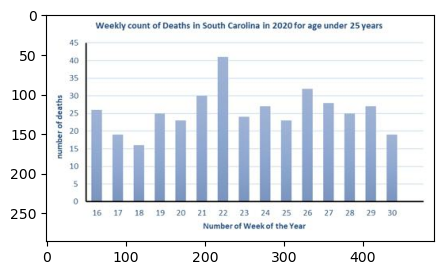

NMS APPLIED MODEL OUTPUT
Color Legend
chart_title  =  b
axis_title  =  g
tick_label  =  r
bar  =  c
other  =  k


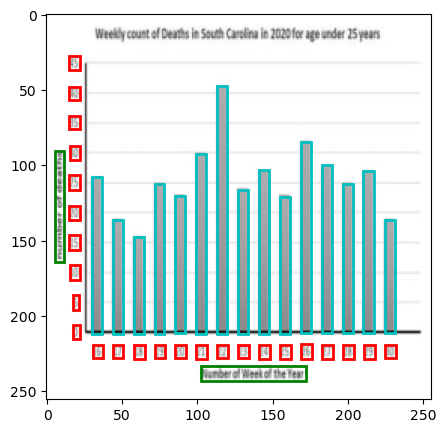

Actual size bounding boxes
Color Legend
chart_title  =  b
axis_title  =  g
tick_label  =  r
bar  =  c
other  =  k


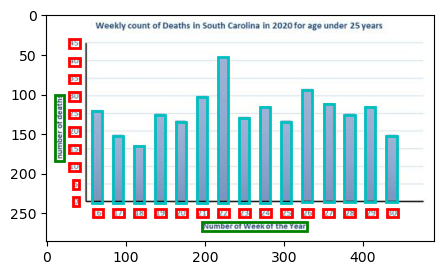

In [12]:
model.eval()
with torch.no_grad():
    prediction = model([img_transformed.to(device)])
    

print('Actual Image')
plot_img(img)
nms_prediction = apply_nms(prediction)
print('NMS APPLIED MODEL OUTPUT')
plot_img_bbox(img_transformed, nms_prediction[0])
rev_pred = rev_transform(nms_prediction, wt, ht)
print('Actual size bounding boxes')
plot_img_bbox(img, rev_pred[0])

In [13]:
classified = classify_bboxes_and_get_orientation(rev_pred)
text_preds_classified = get_text(classified, img)
ds_pred = get_DS(text_preds_classified)

if ds_pred[0]['chart_title'].numel()>0:
    print("Chart Title = ",ds_pred[0]['chart_title_text'][0])
    
if ds_pred[0]['y_axis_title'].numel()>0: 
    print('Y Axis Title = ', ds_pred[0]['y_axis_title_text'][0])

if ds_pred[0]['x_axis_title'].numel()>0: 
    print('X Axis Title = ', ds_pred[0]['x_axis_title_text'][0])

ds = ds_pred[0]['data_series']
ds = pd.DataFrame([ds])

print('Data Series')
print(ds)

Y Axis Title =  number of deaths
X Axis Title =  Number of Week of the Year
Data Series
        16.0       17.0       18.0       19.0       20.0       21.0      22.0  \
0  26.275593  19.057676  16.165941  25.146349  23.133963  30.195679  41.60091   

        23.0       24.0       25.0       26.0       27.0       28.0  \
0  24.120855  27.386711  23.079058  32.059498  28.119787  24.941734   

        29.0       30.0  
0  27.164059  18.939537  
